# Community Dynamic Flux Balance Analysis (cdFBA)

This notebook demonstrates the usage of the [cdFBA](https://github.com/vivarium-collective/cdFBA/tree/main) repository, implemented using the [bigraph-schema](https://github.com/vivarium-collective/bigraph-schema) and [process-bigraph](https://github.com/vivarium-collective/process-bigraph) repositories.

In [75]:
from copy import deepcopy

from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, \
    set_kinetics, model_from_file

from matplotlib import pyplot as plt
from pprint import pprint

# Create Composite Spec for cdFBA Simulation

Automatically generate basic specs for two species of bacteria, *Escherichia coli* and *Shigella flexneri*. We will be using the utility functions found in [this file](https://github.com/vivarium-collective/cdFBA/blob/main/cdFBA/utils.py).

NOTE: The utility functions use the model file's own reaction naming conventions to obtain the name of substrates. These names are not consistent across all metabolic model databases. We have tested these functions on BiGG and AGORA metabolic models and found the naming conventions to be consistent within their respective databases. When using models from different sources, users are advised to map their reactions and substrates of interest before running cdFBA simulations, and avoid the built-in utility functions for creating simulations.

In [76]:
#Create a model dictionary. The keys should be the names of the individual dFBA models/species and the values should be
#BiGG model ids or the path name to the associated model file
model_dict = {
        'E.coli' : 'iAF1260',
        'S.flexneri' : 'iSFxv_1172'
    }
#list exchange reactions
exchanges = ['EX_glc__D_e', 'EX_ac_e']
#set environment volume
volume=2
# define a single dFBA model
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)
# #print spec
pprint(spec)

{'Shared Environment': {'concentrations': {'Acetate': 10.0,
                                           'D-Glucose': 10.0,
                                           'E.coli': 0.25,
                                           'S.flexneri': 0.25},
                        'counts': {'Acetate': 20,
                                   'D-Glucose': 20,
                                   'E.coli': 0.5,
                                   'S.flexneri': 0.5},
                        'volume': 2},
 'Species': {'E.coli': {'_type': 'process',
                        'address': 'local:dFBA',
                        'config': {'bounds': {},
                                   'changes': {'gene_knockout': [],
                                               'reaction_knockout': []},
                                   'kinetics': {'Acetate': (0.5, 2.0),
                                                'D-Glucose': (0.5, 2.0)},
                                   'model_file': 'iAF1260',
                      

In [77]:
#Set reaction bounds
spec['Species']['E.coli']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1}
        }
spec['Species']['S.flexneri']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1}
        }

In [78]:
#set external substrate concentrations
concentrations = {
    "Acetate": 0,
    "D-Glucose": 40
}
set_concentration(spec, concentrations)

In [79]:
#set kinetics
kinetics = {
    "D-Glucose": (0.02, 15),
    "Acetate": (0.5, 7)
}
for species in model_dict.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'Acetate': 0,
                                           'D-Glucose': 40,
                                           'E.coli': 0.25,
                                           'S.flexneri': 0.25},
                        'counts': {'Acetate': 0,
                                   'D-Glucose': 80,
                                   'E.coli': 0.5,
                                   'S.flexneri': 0.5},
                        'volume': 2},
 'Species': {'E.coli': {'_type': 'process',
                        'address': 'local:dFBA',
                        'config': {'bounds': {'ATPM': {'lower': 1, 'upper': 1},
                                              'EX_o2_e': {'lower': -2,
                                                          'upper': None}},
                                   'changes': {'gene_knockout': [],
                                               'reaction_knockout': []},
                                   'kinetics': {'Acetate

# Register Data Types and Processes
Here we register cdFBA related data-types and processes to the `core` object so that the model composite can access them. A `core` object is instantiated using the `ProcessType()` function. Data types are defined in the `init.py` file, and the `register_types()` function registers them to the `core` object. Process registration is done using the `core.register_process()` function.

In [80]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [81]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

### Create Simulation Composite
The `Composite` class creates the simulation object using the spec created earlier.

In [82]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [83]:
#run simulation
sim.run(40)

/opt/anaconda3/envs/fbapractice/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [84]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [85]:
results[0]

{'shared_environment': {'concentrations': {'Acetate': 0,
   'D-Glucose': 40,
   'E.coli': 0.25,
   'S.flexneri': 0.25},
  'counts': {'Acetate': 0, 'D-Glucose': 80, 'E.coli': 0.5, 'S.flexneri': 0.5},
  'volume': 2},
 'global_time': 0.0}

In [86]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

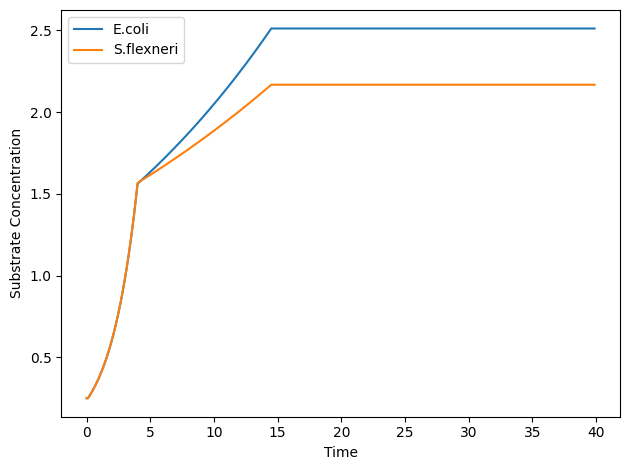

In [87]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

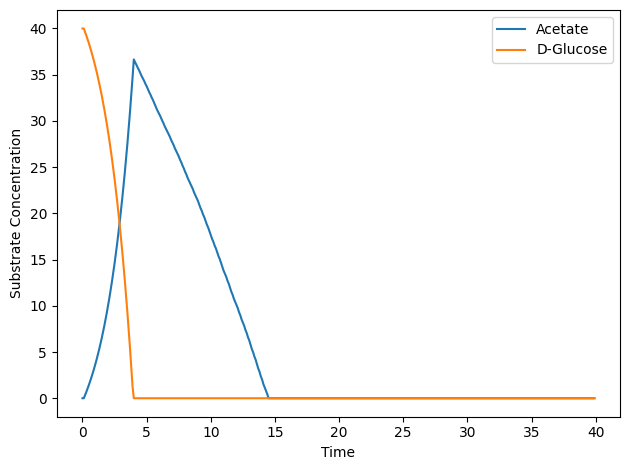

In [88]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

# Environmental Controls

cdFBA includes additional processes to exert control over concentrations of substrates within the shared environment. In the next section we will be demonstrating each of the three processes: `StaticConcentration`, `WaveFunction`, and `Injector`.

### StaticConcentration
The `StaticConcentration` process holds the concentration of a substrate constant to simulate the effects of a StaticConcentration. To demonstrate this, we hold the glucose concentration constant. We must first generate a config dictionary and subsequently add the process specifications to our origina `spec` created above.

In [89]:
StaticConcentration_config = {
    "substrate_concentrations": {
        "D-Glucose": 40
    }
}
spec2 = deepcopy(spec)
spec2['StaticConcentration'] = get_static_spec(StaticConcentration_config, interval=0.1)

In [90]:
sim2 = Composite({
        "state": spec2,
        },
        core=core
    )

In [91]:
sim2.run(40)

In [92]:
#gather results
results = gather_emitter_results(sim2)[('emitter',)]

In [93]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

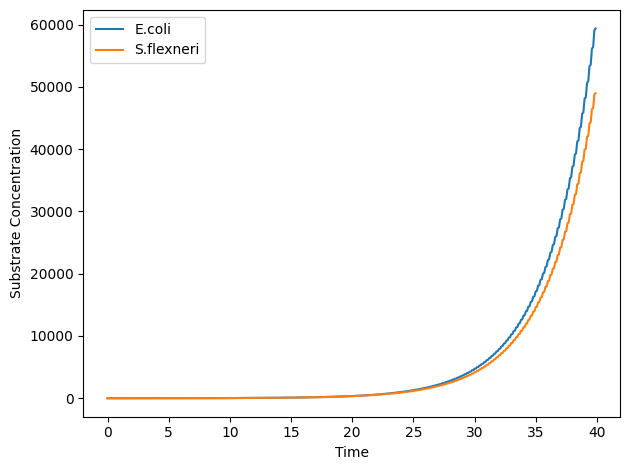

In [94]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

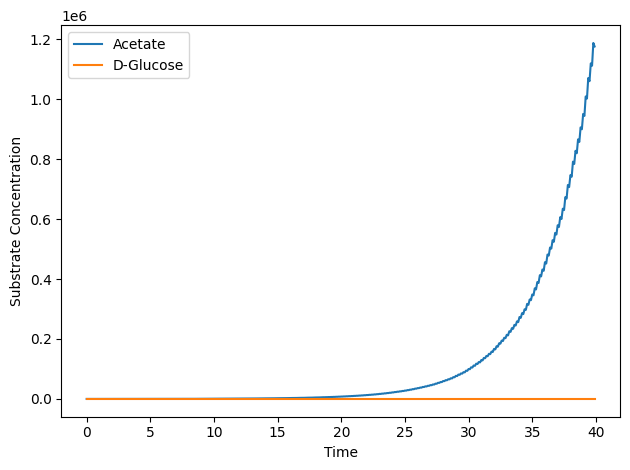

In [95]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in [
        'D-Glucose',
        'Acetate'
    ]:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

### Injector
The `Injector` process periodically injects a specific amount of a substrate into the environment. We similarly create a config and add it to specs, injecting 80 D-Glucose every 5 time steps.

In [96]:
injector_config = {
        "injection_params": {
            "D-Glucose": {
                "amount": 20,
                "interval": 5,
            }
        }
    }
spec3 = deepcopy(spec)
spec3['Injector'] = get_injector_spec(injector_config, interval=0.1)

In [97]:
#set external substrate concentrations
concentrations = {
    "Acetate": 0,
    "D-Glucose": 0
}
set_concentration(spec3, concentrations)

In [ ]:
#Create, run sim, and gather results
sim3 = Composite({
        "state": spec3,
        },
        core=core
    )
sim3.run(40)
results = gather_emitter_results(sim3)[('emitter',)]

In [62]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

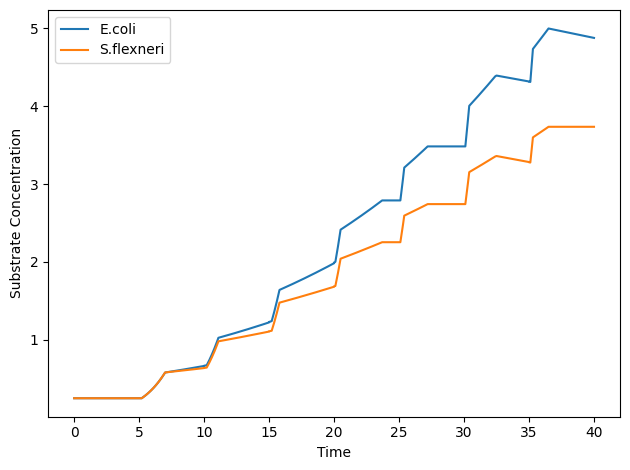

In [63]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

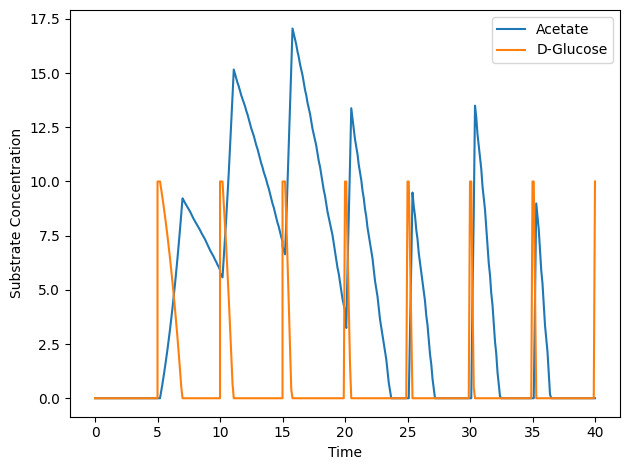

In [64]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

### WaveFunction
The `WaveFunction` process dynamically controls the concentration of a substrate based on a wave function, to simulate cyclic patterns of metabolites in the shared environment. This could be analogous to circadian patterns within human bodies or day-night cycle related fluctuations of metabolite availability in the environment.


In [65]:
wave_config = {
    "substrate_params": {
        "D-Glucose": {
            "amplitude": 5,
            "angular_frequency": 1,
            "base_concentration": 0,
            "phase_shift": 0
        }
    }
}
spec4 = deepcopy(spec)
spec4['Wave Function'] = get_wave_spec(wave_config, interval=0.1)

In [66]:
#set external substrate concentrations
concentrations = {
    "Acetate": 0,
    "D-Glucose": 0
}
set_concentration(spec4, concentrations)

In [67]:
#Create, run sim, and gather results
sim4 = Composite({
        "state": spec4,
        },
        core=core
    )
sim4.run(40)
results = gather_emitter_results(sim4)[('emitter',)]

In [68]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

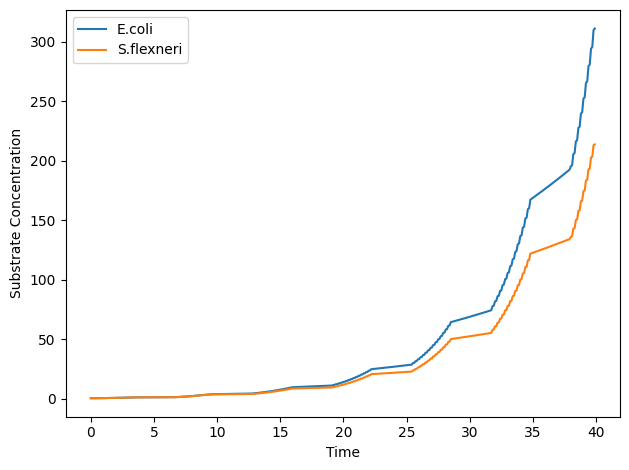

In [69]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

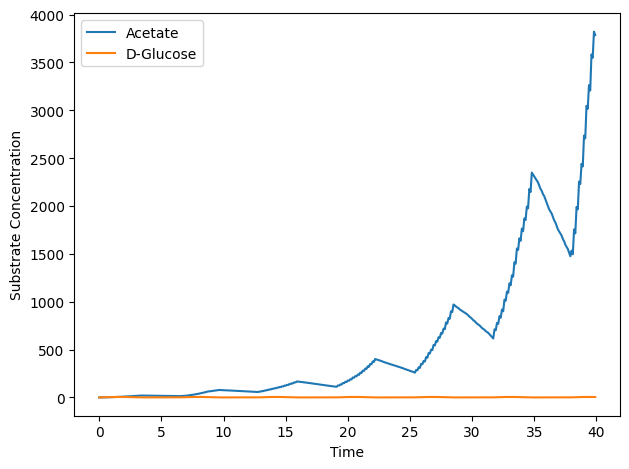

In [70]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['D-Glucose']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
model = model_from_file("textbook")

In [72]:
model.exchanges

[<Reaction EX_ac_e at 0x30bb49ee0>,
 <Reaction EX_acald_e at 0x30bb00f70>,
 <Reaction EX_akg_e at 0x30bae1d00>,
 <Reaction EX_co2_e at 0x30baf2e80>,
 <Reaction EX_etoh_e at 0x30baf2790>,
 <Reaction EX_for_e at 0x30934e520>,
 <Reaction EX_fru_e at 0x30bb1fb20>,
 <Reaction EX_fum_e at 0x30bb1ffd0>,
 <Reaction EX_glc__D_e at 0x30bb1f400>,
 <Reaction EX_gln__L_e at 0x30bb1f8e0>,
 <Reaction EX_glu__L_e at 0x30bb1f640>,
 <Reaction EX_h_e at 0x30bb62790>,
 <Reaction EX_h2o_e at 0x30bb62970>,
 <Reaction EX_lac__D_e at 0x30bb62b80>,
 <Reaction EX_mal__L_e at 0x30bb62ca0>,
 <Reaction EX_nh4_e at 0x30bb62f40>,
 <Reaction EX_o2_e at 0x30bb629a0>,
 <Reaction EX_pi_e at 0x30bb62040>,
 <Reaction EX_pyr_e at 0x30bb62280>,
 <Reaction EX_succ_e at 0x30bb62730>]

In [73]:
for reaction in model.reactions:
    reaction.lower_bound = -1000
    reaction.upper_bound = 1000

In [74]:
for reaction in model.reactions:
    print(reaction.lower_bound)

-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
-1000
